# This notebook makes a machine learning model from a Kaggle dataset about the Big 5 Personality Traits. The goal is to predict the 5th trait given the answers to the questions of the other 4. It is somewhat successful.

### How to interpret the data:
- Answers to the questions are given on a scale of 1 to 5, 1 being strongly disagree, 5 strongly agree
- The average of the 10 questions tells you which side of the scale you are on for that trait. For example, with extraversion a score closer to 1 would mean introverted, a score closer to 5 would mean extraverted, and something in the middle means a little bit of both
- EXT is extraversion
- EST is neuroticism
- AGR is agreeableness
- CSN is conscientiousness
- OPN is openness

In [1]:
#import everything I need, and some things I don't
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, XGBRegressor
from joblib import dump, load
import numpy as np

In [2]:
#read in the dataset and take a look
#interpret 0's as NaN values, since all values should be between 1 and 5
df = pd.read_table('data-final.csv', na_values=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015341 entries, 0 to 1015340
Columns: 110 entries, EXT1 to long_appx_lots_of_err
dtypes: float64(104), int64(2), object(4)
memory usage: 852.1+ MB


In [3]:
def wrangle(data_frame):
    '''Get rid of the columns that aren't part of the 50 question test, and drop NaN values'''
    new_df = data_frame.copy()
    #since the columns I want all end in a number, drop everything that doesn't
    include = ['0','1','2','3','4','5','6','7','8','9']
    for i in new_df.columns:
        if not(i[-1] in include):
            new_df.drop(columns=i, inplace=True)
            
    #drop NaN values, as set above
    new_df.dropna(inplace=True)
            
    return new_df

In [4]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [5]:
#apply the wrangle function and take a look
slim_df = wrangle(df)
print(slim_df.head())
print(slim_df.info())

   EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  ...  OPN1  \
0   4.0   1.0   5.0   2.0   5.0   1.0   5.0   2.0   4.0    1.0  ...   5.0   
1   3.0   5.0   3.0   4.0   3.0   3.0   2.0   5.0   1.0    5.0  ...   1.0   
2   2.0   3.0   4.0   4.0   3.0   2.0   1.0   3.0   2.0    5.0  ...   5.0   
3   2.0   2.0   2.0   3.0   4.0   2.0   2.0   4.0   1.0    4.0  ...   4.0   
4   3.0   3.0   3.0   3.0   5.0   3.0   3.0   5.0   3.0    4.0  ...   5.0   

   OPN2  OPN3  OPN4  OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
0   1.0   4.0   1.0   4.0   1.0   5.0   3.0   4.0    5.0  
1   2.0   4.0   2.0   3.0   1.0   4.0   2.0   5.0    3.0  
2   1.0   2.0   1.0   4.0   2.0   5.0   3.0   4.0    4.0  
3   2.0   5.0   2.0   3.0   1.0   4.0   4.0   3.0    3.0  
4   1.0   5.0   1.0   5.0   1.0   5.0   3.0   5.0    5.0  

[5 rows x 50 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 874434 entries, 0 to 1015340
Data columns (total 50 columns):
 #   Column  Non-Null Count   Dtype  
---  -----

In [6]:
def make_target(data_frame, target_col):
    '''Create the feature matrix and target column with the wrangled dataframe and target
    personality trait as inputs'''
    new_df = data_frame.copy()
    #make a new column of only 0's
    new_df['target'] = [0 for num in range(0, len(slim_df))]
    
    if target_col == 'EXT':
        switch = ['EXT2', 'EXT4', 'EXT6', 'EXT8', 'EXT10']
                    
    elif target_col == 'EST':
        switch = ['EST2', 'EST4']
                    
    elif target_col == 'AGR':
        switch = ['AGR1', 'AGR3', 'AGR5', 'AGR7']
                    
    elif target_col == 'CSN':
        switch = ['CSN2', 'CSN4', 'CSN6', 'CSN8']
                    
    elif target_col == 'OPN':
        switch = ['OPN2', 'OPN4', 'OPN6']
    
    #add all of the numbers from the target personality trait together
    for i in new_df.columns:
        if target_col in i:
                
            if i in switch:
                new_df['target'] = new_df['target'] + (6 - new_df[i])

            else:
                new_df['target'] = new_df['target'] + new_df[i]
                
            new_df.drop(columns=i, inplace=True)
    
    #take the average of the personalitly trait numbers
    true_y = new_df['target'] / 10
    
    #make the feature matrix
    X = new_df.drop(columns='target')
    
    '''Due to the size of this data set, a regression model would take ages to train, so I turned it
    into a classification model I don't know the scale used to interpret these numbers, so I made my own.
    The loop below encodes the target trait averages as 0, 1 or 2, 0 being a low average and 2 being high.
    It loops through different cutoff points to find where to split the data into as close to even thirds
    as possible.'''
    
    lower = 0.1
    upper = 4.9
    l_found = False
    u_found = False
    
    #iterate through the lower and upper cutoffs until the shares of both 0 and 2 are over 0.3
    while not(l_found & u_found): 
        y = []
        
        #create the feature column with the current cutoffs
        for i in true_y:
            if i < lower:
                y.append(0)

            elif (i >= lower) & (i <= upper):
                y.append(1)

            else:
                y.append(2)

        y = pd.Series(y)
        
        #check the share of 0. If it's more than 0.3, stop increasing the lower cutoff
        if 0 in y.value_counts().index:
            if y.value_counts(normalize=True).loc[0] >= 0.32:
                l_found = True
            else:
                lower += 0.1
        else:   
            lower += 0.1
            
        #check the share of 2. If it's more than 0.3, stop decreasing the upper cutoff
        if 2 in y.value_counts().index:
            if y.value_counts(normalize=True).loc[2] >= 0.32:
                u_found = True
            else:
                upper -= 0.1
        else:   
            upper -= 0.1
    
    print(lower, upper)
    
    return X, y

In [7]:
def data_split(X, y):
    '''Split the data into train, validation, and test sets'''
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=11)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
#make the target column, splits and print the baseline for the EXT personality trait
extX, exty = make_target(slim_df, 'EXT')
ext_Xtrain, ext_ytrain, ext_Xval, ext_yval, ext_Xtest, ext_ytest = data_split(extX, exty)
ext_baseline = exty.value_counts(normalize=True).max()
print('EXT Baseline:', ext_baseline)

2.500000000000001 3.300000000000003
EXT Baseline: 0.3473080872884632


In [9]:
#make the target column, splits and print the baseline for the EST personality trait
estX, esty = make_target(slim_df, 'EST')
est_Xtrain, est_ytrain, est_Xval, est_yval, est_Xtest, est_ytest = data_split(estX, esty)
est_baseline = esty.value_counts(normalize=True).max()
print('EST Baseline:', est_baseline)

2.600000000000001 3.400000000000003
EST Baseline: 0.3464217997012925


In [10]:
#make the target column, splits and print the baseline for the AGR personality trait
agrX, agry = make_target(slim_df, 'AGR')
agr_Xtrain, agr_ytrain, agr_Xval, agr_yval, agr_Xtest, agr_ytest = data_split(agrX, agry)
agr_baseline = agry.value_counts(normalize=True).max()
print('AGR Baseline:', agr_baseline)

3.5000000000000018 4.100000000000003
AGR Baseline: 0.33810785033518825


In [11]:
#make the target column, splits and print the baseline for the CSN personality trait
csnX, csny = make_target(slim_df, 'CSN')
csn_Xtrain, csn_ytrain, csn_Xval, csn_yval, csn_Xtest, csn_ytest = data_split(csnX, csny)
csn_baseline = csny.value_counts(normalize=True).max()
print('CSN Baseline:', csn_baseline)

3.0000000000000013 3.600000000000003
CSN Baseline: 0.3615710276590343


In [12]:
#make the target column, splits and print the baseline for the OPN personality trait
opnX, opny = make_target(slim_df, 'OPN')
opn_Xtrain, opn_ytrain, opn_Xval, opn_yval, opn_Xtest, opn_ytest = data_split(opnX, opny)
opn_baseline = opny.value_counts(normalize=True).max()
print('OPN Baseline:', opn_baseline)

3.600000000000002 4.100000000000003
OPN Baseline: 0.3771639712088048


In [13]:
#create and fit a Logistic Regression Cross Validation model on the EXT personality trait
lr_model = LogisticRegressionCV(cv=5, n_jobs=8)
lr_model.fit(ext_Xtrain, ext_ytrain);

In [14]:
#get the scores for the above model
print('Training Score:', lr_model.score(ext_Xtrain, ext_ytrain))
print('Validation Score:', lr_model.score(ext_Xval, ext_yval))
print('Test Score:', lr_model.score(ext_Xtest, ext_ytest))

Training Score: 0.5620035844663595
Validation Score: 0.5622185690801229
Test Score: 0.5645531114376712


In [15]:
def make_model(X_train, y_train, X_val, y_val):
    '''A function that takes training and validation data as inputs, makes and fits a model,
    and returns that model'''
    val_set = [(X_val, y_val)]

    #create the XGBClassifer model. I gave it a ton of estimators, but told it to stop with no change in 10 rounds
    model = XGBClassifier(n_estimators=1000,
                          eval_set=val_set,
                          eval_metric='merror',
                          early_stopping_rounds=10,
                          random_state=11,
                          n_jobs=8)
    
    #fit the model on the training data
    model.fit(X_train, y_train);
    
    #print the scores on the given training and validation set
    print('Training Score:', model.score(X_train, y_train))
    print('Validation Score:', model.score(X_val, y_val))
    
    return model

# The cells below are commented out so they don't run every time I execute this code from scratch. The models take ages to train, so I saved them to external files and load those in instead

In [16]:
#create the EXT model and print the test score
'''ext_model = make_model(ext_Xtrain, ext_ytrain, ext_Xval, ext_yval)
print('EXT Test Score:', ext_model.score(ext_Xtest, ext_ytest))'''

"ext_model = make_model(ext_Xtrain, ext_ytrain, ext_Xval, ext_yval)\nprint('EXT Test Score:', ext_model.score(ext_Xtest, ext_ytest))"

In [17]:
#create the EST model and print the test score
'''est_model = make_model(est_Xtrain, est_ytrain, est_Xval, est_yval)
print('EST Test Score:', est_model.score(est_Xtest, est_ytest))'''

"est_model = make_model(est_Xtrain, est_ytrain, est_Xval, est_yval)\nprint('EST Test Score:', est_model.score(est_Xtest, est_ytest))"

In [18]:
#create the AGR model and print the test score
'''agr_model = make_model(agr_Xtrain, agr_ytrain, agr_Xval, agr_yval)
print('AGR Test Score:', agr_model.score(agr_Xtest, agr_ytest))'''

"agr_model = make_model(agr_Xtrain, agr_ytrain, agr_Xval, agr_yval)\nprint('AGR Test Score:', agr_model.score(agr_Xtest, agr_ytest))"

In [19]:
#create the CSN model and print the test score
'''csn_model = make_model(csn_Xtrain, csn_ytrain, csn_Xval, csn_yval)
print('CSN Test Score:', csn_model.score(csn_Xtest, csn_ytest))'''

"csn_model = make_model(csn_Xtrain, csn_ytrain, csn_Xval, csn_yval)\nprint('CSN Test Score:', csn_model.score(csn_Xtest, csn_ytest))"

In [20]:
#create the OPN model and print the test score
'''opn_model = make_model(opn_Xtrain, opn_ytrain, opn_Xval, opn_yval)
print('OPN Test Score:', opn_model.score(opn_Xtest, opn_ytest))'''

"opn_model = make_model(opn_Xtrain, opn_ytrain, opn_Xval, opn_yval)\nprint('OPN Test Score:', opn_model.score(opn_Xtest, opn_ytest))"

In [21]:
#save all of the models to external files so I don't have to re-train them every time I run this code
'''dump(ext_model, 'extmodel.joblib')
dump(est_model, 'estmodel.joblib')
dump(agr_model, 'agrmodel.joblib')
dump(csn_model, 'csnmodel.joblib')
dump(opn_model, 'opnmodel.joblib')'''

"dump(ext_model, 'extmodel.joblib')\ndump(est_model, 'estmodel.joblib')\ndump(agr_model, 'agrmodel.joblib')\ndump(csn_model, 'csnmodel.joblib')\ndump(opn_model, 'opnmodel.joblib')"

## End of commented out code

In [22]:
#load and print the scores for the EXT model
ext_model = load('extmodel.joblib')
print('EXT Training Score:', ext_model.score(ext_Xtrain, ext_ytrain))
print('EXT Validation Score:', ext_model.score(ext_Xval, ext_yval))
print('EXT Test Score:', ext_model.score(ext_Xtest, ext_ytest))

EXT Training Score: 0.7058700550535436
EXT Validation Score: 0.5670073618754914
EXT Test Score: 0.5677952049037378


In [23]:
#load and print the scores for the EST model
est_model = load('estmodel.joblib')
print('EST Training Score:', est_model.score(est_Xtrain, est_ytrain))
print('EST Validation Score:', est_model.score(est_Xval, est_yval))
print('EST Test Score:', est_model.score(est_Xtest, est_ytest))

EST Training Score: 0.6942535965277492
EST Validation Score: 0.545414909584733
EST Test Score: 0.5444944449844757


In [24]:
#load and print the scores for the AGR model
agr_model = load('agrmodel.joblib')
print('AGR Training Score:', agr_model.score(agr_Xtrain, agr_ytrain))
print('AGR Validation Score:', agr_model.score(agr_Xval, agr_yval))
print('AGR Test Score:', agr_model.score(agr_Xtest, agr_ytest))

AGR Training Score: 0.6932868984716879
AGR Validation Score: 0.5438639125151883
AGR Test Score: 0.5446088045423616


In [25]:
#load and print the scores for the CSN model
csn_model = load('csnmodel.joblib')
print('CSN Training Score:', csn_model.score(csn_Xtrain, csn_ytrain))
print('CSN Validation Score:', csn_model.score(csn_Xval, csn_yval))
print('CSN Test Score:', csn_model.score(csn_Xtest, csn_ytest))

CSN Training Score: 0.6598294966201306
CSN Validation Score: 0.5032377957258237
CSN Test Score: 0.5027932322013643


In [26]:
#load and print the scores for the OPN model
opn_model = load('opnmodel.joblib')
print('OPN Training Score:', opn_model.score(opn_Xtrain, opn_ytrain))
print('OPN Validation Score:', opn_model.score(opn_Xval, opn_yval))
print('OPN Test Score:', opn_model.score(opn_Xtest, opn_ytest))

OPN Training Score: 0.6851155302454984
OPN Validation Score: 0.5340576084625831
OPN Test Score: 0.5320464071085901


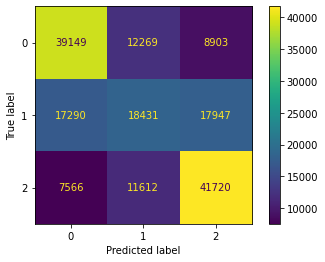

In [27]:
#create a confusion maxtrix to use as a visualization on the blogpost
plot_confusion_matrix(ext_model,
                      ext_Xtest,
                      ext_ytest,
                      values_format='.0f');